In [67]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import time as ts
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from importlib import reload
import optyEngine as oe
reload (oe);

In [68]:
### BY JASON MOORE ###
# just different way how create equations of motion,
# here one more speed is introduced, but this approach has a singularity when q0=0

import sympy.physics.mechanics as me
import sympy as sp

t = sp.symbols('t')
q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B = me.dynamicsymbols('q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B')  # quaternion
w1A, w2A, w3A, w1B, w2B, w3B = me.dynamicsymbols('w1A, w2A, w3A, w1B, w2B, w3B')  # angular velocities
u0A, u0B = me.dynamicsymbols('u0A u0B')
l = 5
m = 10
g = 9.81
Ixx = 10
Iyy = 1
Izz = 5
F = me.dynamicsymbols('F1:7')


N = me.ReferenceFrame('frame_ground')
N0 = me.Point('point_ground')
N0.set_vel(N,0)

A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
mA = me.Point('mA')
mB = me.Point('mB')
ABj = me.Point('ABj')


A.orient(N, 'Quaternion', [q0A, q1A, q2A, q3A])

N_w_A = A.ang_vel_in(N)
 
kinematical1 = sp.Matrix([
    u0A - q0A.diff(t),
    w1A - N_w_A.dot(A.x),
    w2A - N_w_A.dot(A.y),
    w3A - N_w_A.dot(A.z),
])

B.orient(A, 'Quaternion', [q0B, q1B, q2B, q3B])

A_w_B = B.ang_vel_in(A)

kinematical2 = (sp.Matrix([
    u0B - q0B.diff(t),
    w1B - A_w_B.dot(B.x),
    w2B - A_w_B.dot(B.y),
    w3B - A_w_B.dot(B.z),
]))

A.set_ang_vel(N, w1A*A.x + w2A*A.y + w3A*A.z)
B.set_ang_vel(A, w1B*B.x + w2B*B.y + w3B*B.z)

mA.set_pos(N0, -l/2 * A.z)
mA.v2pt_theory(N0,N,A)
FG1 = [(mA, -m * g * N.z)]

ABj.set_pos(N0, -l * A.z)
ABj.v2pt_theory(N0,N,A)


mB.set_pos(ABj, -l/2 * B.z)
mB.v2pt_theory(ABj,N,B)


I1 = me.inertia(A, Ixx, Iyy, Izz)
I2 = me.inertia(B, Ixx, Iyy, Izz)

BODY = []
BODY.append(me.RigidBody('Abody', mA, A, m, (I1, mA)))
BODY.append(me.RigidBody('Bbody', mB, B, m, (I2, mB)))

kinematical = sp.Matrix([[kinematical1],[kinematical2]])

FG2 = [(mB, -m * g * N.z)]
Torque1 = [(A, 500*(F[0]*A.x+F[1]*A.y+F[2]*A.z))]
Torque2 = [(B, 500*(F[3]*B.x+F[4]*B.y+F[5]*B.z))]


holonomic = sp.Matrix([[q0A**2 + q1A**2 + q2A**2 + q3A**2 - 1],
                       [q0B**2 + q1B**2 + q2B**2 + q3B**2 - 1]])
kane = me.KanesMethod(
    N,
    [q1A, q2A, q3A, q1B, q2B, q3B],
    [w1A, w2A, w3A, w1B, w2B, w3B],
    kd_eqs=kinematical,
    q_dependent=[q0A,q0B],
    u_dependent=[u0A,u0B],
    configuration_constraints=holonomic,
    velocity_constraints=holonomic.diff(t),
)
(fr, frstar) = kane.kanes_equations(BODY, (FG1+FG2+Torque1+Torque2))

In [69]:
eoms = sp.Matrix(kinematical).col_join(fr+frstar).col_join(holonomic)

In [70]:
duration = 1 # seconds
num_nodes = 101
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)

state_symbols = (q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B, w1A, w2A, w3A, w1B, w2B, w3B, u0A, u0B)
num_states = len(state_symbols)
specified_symbols = tuple(F)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [71]:
import optyEngine as oe
reload (oe);
eul,deul = oe.create_trajectory(num_nodes,duration,interval_value)
traj,w= oe.eul2quat_traj(num_nodes,eul,interval_value)
quat_traj_guess = np.concatenate((traj,w)).flatten()

In [72]:
objective_traj,objective_traj_jac = oe.objective_function(8,interval_value)
objective_traj_RG,objective_traj_RG_jac = oe.objective_rotglob_quat(8,interval_value)
w_traj = 300
w_vel = 0.01
w_force = 0.1
def obj(free):
    min_traj = w_traj * np.sum(objective_traj(np.split(free[:4*2*num_nodes],8),traj))
    min_vel = w_vel * interval_value * np.sum(free[4*2*num_nodes:8*2*num_nodes]**2)
    min_torque = w_force * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:4*2*num_nodes] = w_traj * np.concatenate(objective_traj_jac(np.split(free[:4*2*num_nodes],8),traj))
    grad[4*2*num_nodes:8*2*num_nodes] = w_vel * 2 * interval_value * free[4*2*num_nodes:8*2*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = w_force * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

Matrix([[-2*x3**2 - 2*x4**2 + 1], [2*x1*x4 + 2*x2*x3], [-2*x1*x3 + 2*x2*x4], [0]])


In [73]:
# w_traj = 100
# w_vel = 0
# w_force = 0.1

# def obj(free):
#     min_traj = w_traj * interval_value * np.sum((quat_traj - free[:4*2*num_nodes])**2)
#     min_vel = w_vel * interval_value * np.sum(free[3*2*num_nodes:6*2*num_nodes]**2)
#     min_torque = w_force * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
#     return min_traj + min_torque + min_vel

# def obj_grad(free):
#     grad = np.zeros_like(free)
#     grad[:4*2*num_nodes] = w_traj * 2.0 * interval_value * (free[:4*2*num_nodes] - quat_traj)
#     grad[4*2*num_nodes:7*2*num_nodes] = w_vel * 2 * interval_value * free[3*2*num_nodes:6*2*num_nodes]
#     grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = w_force * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
#     return grad

In [74]:
instance_constraints = (
    # q0A.func(0.0) - 1,
    # q1A.func(0.0) - 0,
    # q2A.func(0.0) - 0,
    # q3A.func(0.0) - 0,
    # q0B.func(0.0) - 1,
    # q1B.func(0.0) - 0,
    # q2B.func(0.0) - 0,
    # q3B.func(0.0) - 0,
    # w1A.func(0.0) - 0,
    # w2A.func(0.0) - 0,
    # w3A.func(0.0) - 0,
    # w1B.func(0.0) - 0,
    # w2B.func(0.0) - 0,
    # w3B.func(0.0) - 0,
    # u0A.func(0.0) - 0,
    u0B.func(0.0) - 0,
)

max_force = 50000.0
bounds = {
    F[0]: (-max_force, max_force),
    F[1]: (-max_force, max_force),
    F[2]: (-max_force, max_force),
    F[3]: (-max_force, max_force),
    F[4]: (-max_force, max_force),
    F[5]: (-max_force, max_force),
}

In [75]:
start = ts.time()

prob = Problem(obj, obj_grad, eoms, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bounds,
               integration_method='midpoint')

# prob.add_option('nlp_scaling_method', 'gradient-based')

time_to_create = ts.time() - start
print(time_to_create)


10.757724046707153


In [76]:
initial_guess = np.random.randn(prob.num_free)*0
# initial_guess = np.ones(prob.num_free)*0.1
initial_guess[:8*2*num_nodes] = quat_traj_guess
prob.add_option('max_iter',15000)

In [77]:
start = ts.time()

solution, info = prob.solve(initial_guess)

time_to_create = ts.time() - start
print(time_to_create)
print(info['status_msg'])
print(info['obj_val'])

19.90353751182556
b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'
0.291574353131523


In [78]:
# fig, axes = plt.subplots(22, 1, sharex=True,
#                          figsize=(6.4, 0.8*40),
#                          layout='compressed')
# prob.plot_trajectories(solution, axes=axes)

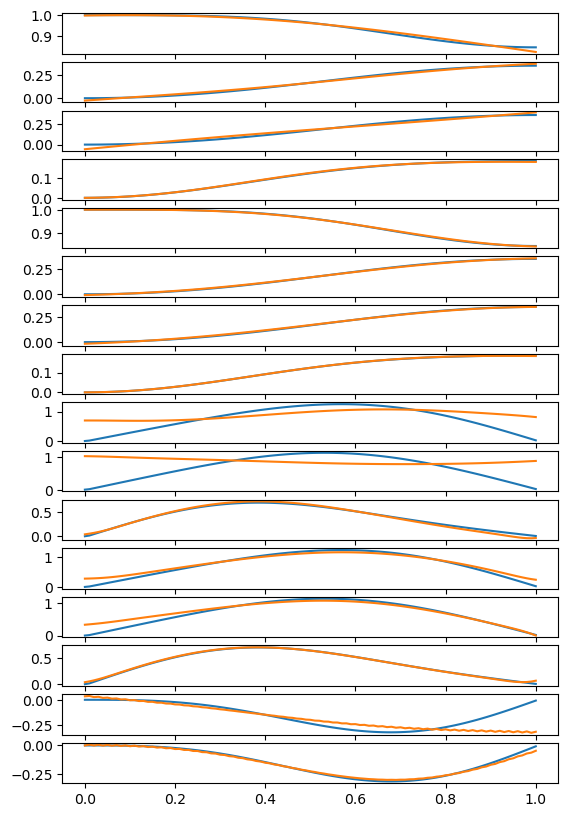

In [79]:
fig, axs = plt.subplots(16)
for j in range(16):
    axs[j].plot(time,quat_traj_guess[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [80]:
reload (oe);
oe.plot_results(solution,quat_traj[0:len(quat_traj)//2],time,num_nodes)

ValueError: cannot reshape array of size 40 into shape (4,101)